In [117]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [118]:
D_NFFT = 4096   # 4096 points FFT
D_FS = 44100    # sampling frequency
D_OVL = 2       # each (time-)window overlaps with 1/2 of the former window

# which means, if the input audio's Fs=44100 Hz, and NFFT=4096, 
# then we first do FFT toward the beginning 4096 values, 
#       second, do FFT toward the 2049 ~ (4096 + 2048) values, 
#         then, do FFT toward the 4097 ~ (4096 + 4096) values,
#         and so on... until the end.
#
# Finally, we'll get a time-frequency spectrum.
# ( i.e., 2D matrix, each element is the [energy]
#   of a specific [frequency] in a specific [time-window] )

# Let's see it later.

In [119]:
nfft = D_NFFT
fs = D_FS
ovl = D_OVL

In [120]:
fs, audio = wavfile.read('Y:\演奏\\20200202\\10 元气少女\\200130_2146_01.wav')

In [121]:
print(fs, type(audio))
print(audio.shape)
print(audio.dtype)
print(round(audio.shape[0] / fs, 6), 'seconds')

44100 <class 'numpy.ndarray'>
(1636811, 2)
int32
37.115896 seconds


In [122]:
print(audio[:8])
# the beginning frament of audio data. 
# we can see that it's a time series, it has 2 channels

[[  4347392 -13238016]
 [  5658624 -14789632]
 [  5207040 -14689536]
 [  4581376 -13148416]
 [  4084480 -12113408]
 [  3584000 -11469312]
 [  2921216 -10913280]
 [  2366208  -9649408]]


In [123]:
audLeft = list(map(lambda x: x[0], audio))  # discard the right channel
print(len(audLeft))
print(audLeft[:8])

1636811
[4347392, 5658624, 5207040, 4581376, 4084480, 3584000, 2921216, 2366208]


<class 'numpy.ndarray'>
(2049, 798)
float64


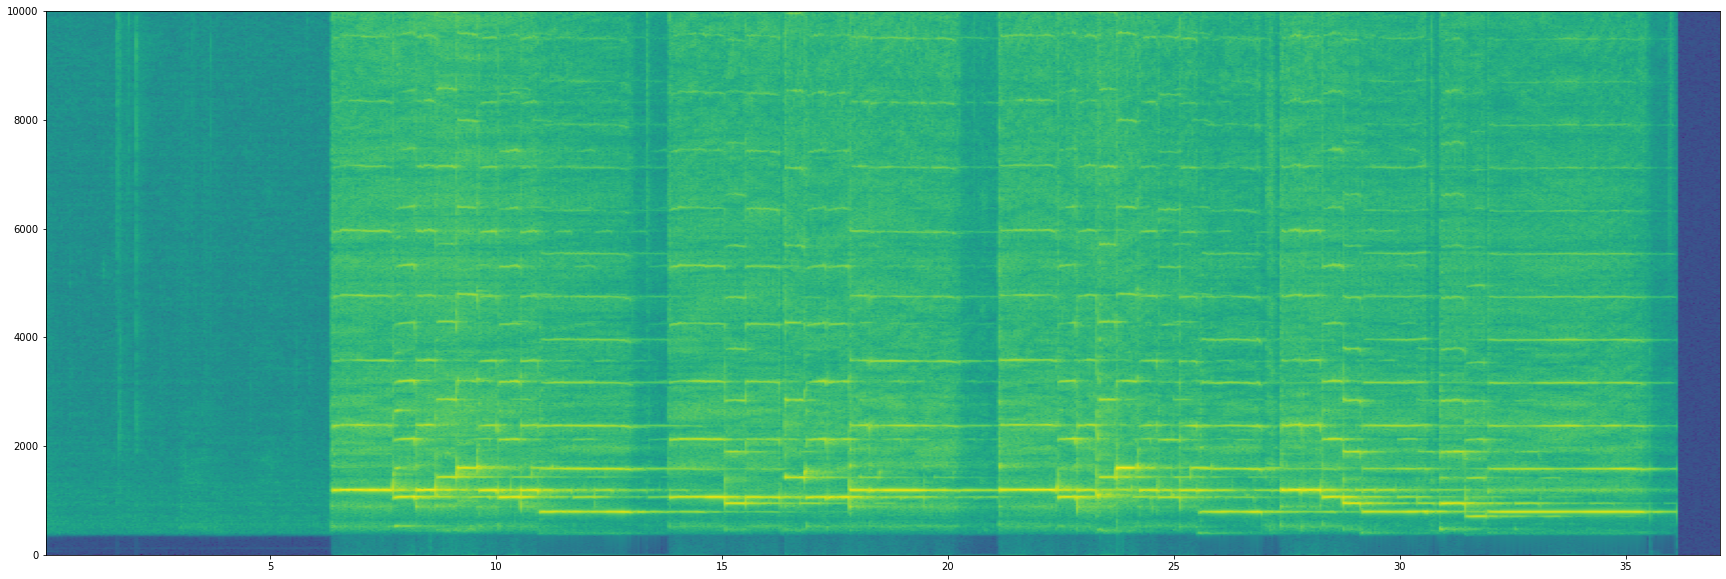

In [124]:
fig, ax2 = plt.subplots(figsize = (30, 10))
# do FFT to get spectrum
# the output data has 3 dimensions:
# time, frequency, energy. 
# 'sp2D' is exactly the 2D matrix that I've mentioned at first.
sp2D, freqs, bins, im = ax2.specgram( audLeft,
                                      NFFT = D_NFFT,
                                      Fs = D_FS,
                                      noverlap = nfft // ovl)
plt.ylim(0, 1e4)

print(type(sp2D))
print(sp2D.shape)
print(sp2D.dtype)

# Let's see the figure
# the horizontal axis is time
# the vertical axis is frequency
# the brighter color, the higher energy

In [125]:
# we notice that
# the bottom group of "lines" are obviously brighter than other "lines"
# these "lines" represent the fundamental frequencies

# and there are a few groups that seems identical to the fundamental group
# but darker
# they are the second/third/forth... harmonics
# (also known as overtones, the reason of timbre)
# anyways, if the information of fundamental frequency is enough for us,
# then we can just ignore all the harmonics

# I'm going to plot another figure, 0 ~ 2500 Hz only
# to focus on the fundamental freq 
# (the fundamental freq of flute is upper-bounded by 2489 Hz)

(0.0, 2500.0)

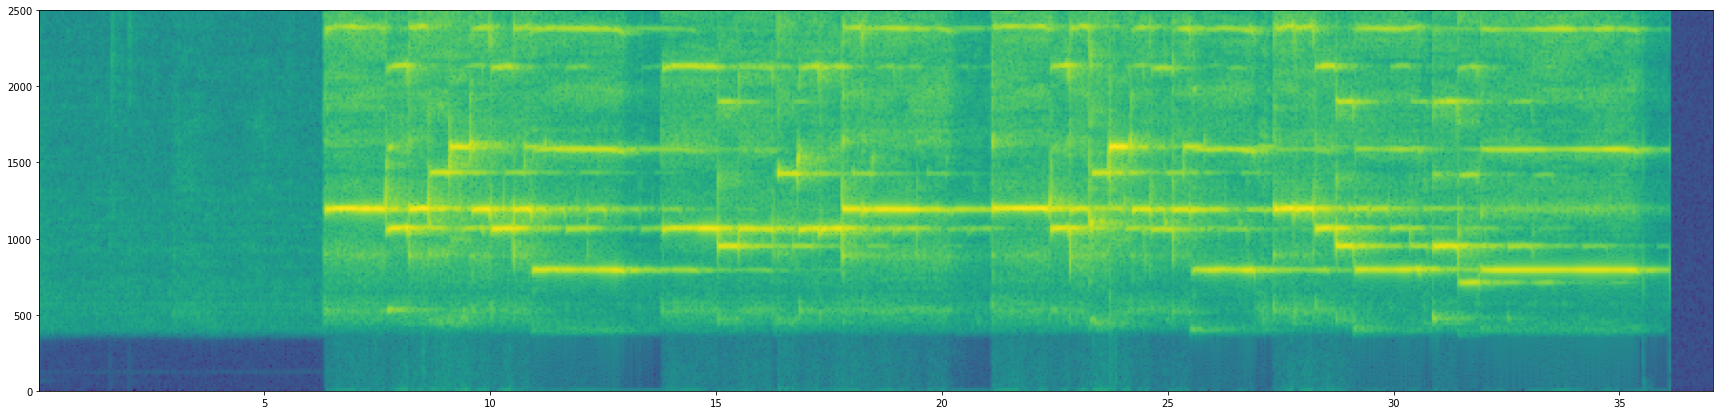

In [126]:
fig, ax1 = plt.subplots(figsize = (30, 7))
sp2D, freqs, bins, im = ax1.specgram( audLeft,
                                     NFFT = D_NFFT,
                                     Fs = D_FS,
                                     noverlap = nfft // ovl)
plt.ylim(0, 2500)

In [127]:
# According to the table on Wikipedia
# https://en.wikipedia.org/wiki/Piano_key_frequencies#List
# We now can recognize the pitch of each piece of music
# for example, the first note (look at the left most thick yellow segment),
# its frequency is around 1200 Hz (by observation)
# (energy peaked around 1194 Hz)
# (if we calculated the average of values nearby,
#  we'd get a more accurate frequency. 
#  currently it's just a lazy way here, but accurate enough)
import operator
mInd, mVal = max( enumerate(sp2D[:, int(sp2D.shape[1] * 7 / 37.1)]), 
                  key = operator.itemgetter(1) )
print( int(mInd * fs / (nfft + 2)), 'Hz' )

1194 Hz


In [128]:
# According to the table,
# D6 should be 1175 Hz
# D#6 should be 1245 Hz
# Db6 should be 1109 Hz

# Besides, our frequency domain resolution (for this notebook)
# equals 44100 / 2 / (4096 / 2 + 1) ≈ 10.8 Hz

# Thus, we can deduce that the pitch of the first note must be D6. 

# Then, how long does the note last? 
# We notice that there are lots of "vertical lines" in the figure.
# Why?
# Because something SUDDENLY happens. 
# Likes, we say 'aaaaaaaa' and then stop, or 'aaaaaa-bbbbb', 
# when we change our sound, we make some weird shakes that
# cover more frequencies. 

# So we can utilize the 'vertical lines' to determine
# whether a note has finished or not. 
# I'll illustrate a little bit more in the next sample. 

In [129]:
# Pictures with some marks are in the repository.
# Basically, these are the main ideas for minimal viable product without ML. 
# I ignored quite a few details, which means, with some optimizations, 
# this could be more optimistic. 

# For example, 
# (1) we can easily recognize the ambient noise. 
#     (for this input, the begining 6 seconds)
#     and higher than 400 Hz, it's almost white.
#     if we make our data minus the average of ambient noise.
#     imagine that, the information will be much clearer. 
# (2) if we optimize the parameters such as 
#     frequency domain resolution or overlapping rate. 
# (3) The reason why every valuable bright segment is followed
#     by a slightly darker tail is that
#     this input has already been added strong reverberations. 
#     (likes a simulation of in a certain environment
#      such as room/concert hall/car that reflets sound wave)
#     This already made thing harder but as you can see, 
#     we still have some ways out. 
# (4) what if we make use of harmonics?

# In conclusion, 
# I believe we are able to build a solid basic algorithm in few weeks 
# for the basic target, i.e., flute solo. 
# And then try to increase its appetite. 

# However, 
# I still wanna point out that to get the "standard answer" for testing,
# we need to either build an auxiliary system or do quite amount of manual works.

In [130]:
# Another sample
fs, audio = wavfile.read('Y:\演奏\\20200202\\18 银仙ED\\200131_2155.wav')
audLeft = list(map(lambda x: x[0], audio))

In [131]:
print(fs, type(audio))
print(audio.shape)
print(audio.dtype)
print(round(audio.shape[0] / fs, 6), 's')

44100 <class 'numpy.ndarray'>
(2002088, 2)
int32
45.398821 s


(0.0, 2500.0)

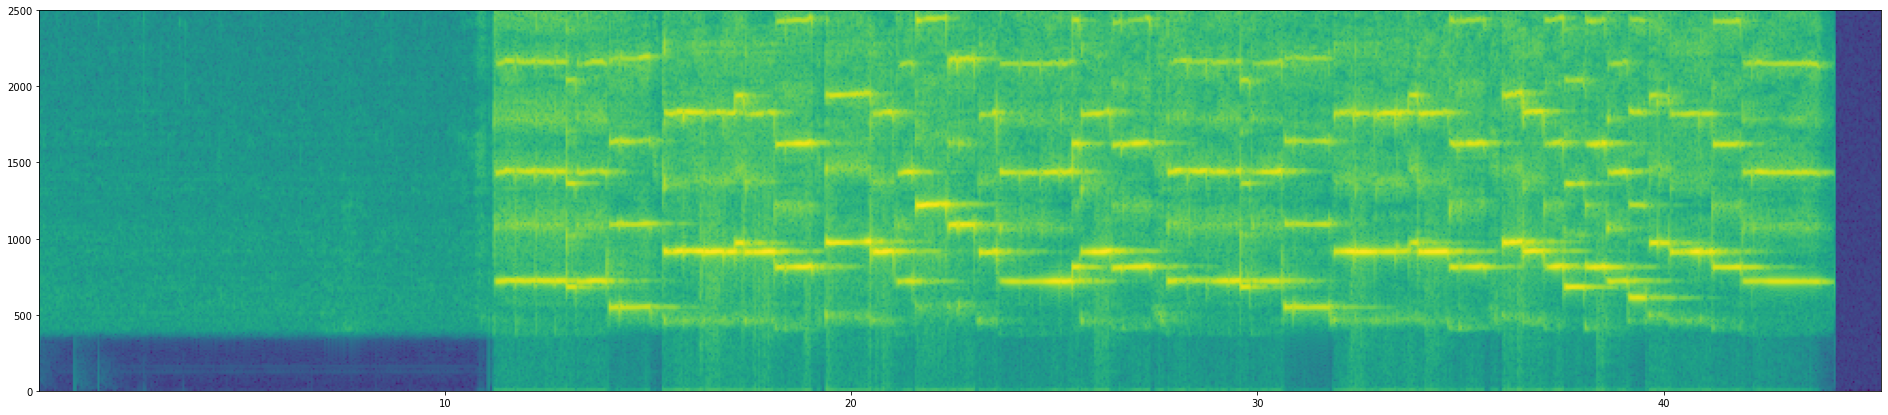

In [132]:
fig, ax3 = plt.subplots(figsize = (33, 7))
sp2D, freqs, bins, im = ax3.specgram( audLeft,
                                     NFFT = D_NFFT,
                                     Fs = D_FS,
                                     noverlap = nfft // ovl)
plt.ylim(0, 2500)

In [133]:
# The beginning of this music sounds like the following:
# F5~~ F5~~ F5~~ F5~ E5~ F5~~~ C5~ C5~~~ rest~
# A5~~ A5~~ A5~~ A5~ Bb5~ A5~~~ G5~ G5~~~ rest~

# ~ represents an unit of time.
# Bb represents the note between B and A.

# Anyways, the point is in some time slots, 
# the pitch (level of frequency) remains unchanged, 
# but there are several momentary pauses in the slot. 

# With the "vertical lines" that I mentioned before, 
# the "long horizontal lines" can be splited accurately, 
# even the pauses are very short. 

# The marked figure is the repository.

In [134]:
print("Thanks for reading and corrections!")

Thanks for reading and corrections!
